In [ ]:
!pip install pandas openai pymongo pypdf langchain_community tqdm tenacity scikit-learn tiktoken python-dotenv seaborn qdrant-client fastembed==0.1.1 --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.41.2 requires tokenizers<0.20,>=0.19, but you have tokenizers 0.13.3 which is incompatible.


# RAG System with MongoDB as vector search engine

## Parsing the pdf and cleaning it

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

# The url for the user manual pdf.
url = "https://raw.githubusercontent.com/MatthewHsu1/RAGsystemOpenAI/main/F80_F83_F85_OM_810.pdf"

# Initialize PyPDFLoader with downloaded user manual pdf
loader = PyPDFLoader(url)
pages = loader.load_and_split()

In [ ]:
# First create a dictionary of headers to parse the pdf by headers.

headers = [
    "TABLE OF CONTENTS",
    "PRODUCT REGISTRATION",
    "IMPORTANT SAFETY INSTRUCTIONS",
    "IMPORTANT ELECTRICAL INSTRUCTIONS",
    "GROUNDING INSTRUCTIONS",
    "IMPORTANT OPERATION INSTRUCTIONS",
    "IMPORTANT SAFETY INSTRUCTIONS",
    "IMPORTANT SAFETY INSTRUCTIONS",
    "PREVENTATIVE MAINTENANCE CHART",
    "F80 / F83 / F83 ASSEMBLY PACK CHECKLIST",
    "F80 / F83 / F83 ASSEMBLY INSTRUCTIONS",
    "FOLDING INSTRUCTIONS",
    "TRANSPORTATION INSTRUCTIONS",
    "OPERATION OF YOUR TREADMILL",
    "GETTING STARTED",
    "QUICK-START OPERATION",
    "PAUSE/STOP/RESET FEATURE",
    "INCLINE FEATURE",
    "DOT MATRIX CENTER DISPLAY",
    "PROGRAMMABLE FEATURES",
    "HEART RATE PROGRAMS",
    "USING HEART RATE TRANSMITTER",
    "GENERAL MAINTENANCE",
    "BELT ADJUSTMENTS",
    "TREAD-BELT TRACKING ADJUSTMENT",
    "BELT/DECK LUBRICATION",
    "SERVICE CHECKLIST - DIAGNOSIS GUIDE",
    "MANUFACTURER’S LIMITED WARRANTY"
]

In [ ]:
import re

def strip_top(page):
  """
    Every document inside the variable of pages has this string in the beginning, 'F80 /  F83 / F85 TREADMILL'.
    Therefore, the real content of the pdf begins after that string.
  """
  pattern = r"F80 /  F83 / F85 TREADMILL(.*)"
  for page in pages:
    match = re.search(pattern, page.page_content, re.DOTALL)

    clean_text = ""
    if match:
        clean_text = match.group(1).strip()
        clean_text = clean_text.replace("\n", " ")
        clean_text = clean_text.replace("\x84", "")
        clean_text = re.sub(r'\s+', ' ', clean_text)
        page.page_content = clean_text
    else:
      clean_text = page.page_content.replace("\n", " ")
      clean_text = clean_text.replace("\x84", "")
      clean_text = re.sub(r'\s+', ' ', clean_text)
      page.page_content = clean_text

In [ ]:
# The pdf is in plain text
strip_top(pages)

In [ ]:
import re

def split_by_header(headers, pages):

  list_of_string = []
  for page in pages:

    # Create a regular expression that pattern matches all strings in headers.
    pattern = '|'.join(map(re.escape, headers))

    # Split each page by the pattern created.
    split_result = re.split(pattern, page.page_content)

    # Get rid of any empty strings
    split_result = [s.strip() for s in split_result if s.strip() != '']

    list_of_string += split_result

  return list_of_string

In [ ]:
text = split_by_header(headers, pages)

In [ ]:
# Check to see if any string in the list has the possibility to exceed the text embedding token limit.

for string in text:
  word_count = len(string.split())
  assert (word_count <= 5500) == True, "A string may potentially exceed the token limit"

In [ ]:
#Convert the list 'text' into a panda dataframe.

import pandas as pd

dataset_df = pd.DataFrame(text)
dataset_df.columns = ['text']

(43, 1)

## Transform the pdf into vector embeddings and store it inside of MongoDB

In [ ]:
import openai
from google.colab import userdata

openai.api_key = userdata.get('open_ai')

EMBEDDING_MODEL = 'text-embedding-3-small'

# This method will take a text and get an vector embedding from OpenAI
def get_embedding(text):
  if not text or not isinstance(text, str):
    return None

  try:
    embedding = openai.embeddings.create(input=text, model=EMBEDDING_MODEL).data[0].embedding
    return embedding
  except Exception as e:
    print(f'Error in get_embedding: {e}')
    return None

dataset_df['embedding'] = dataset_df['text'].apply(get_embedding)

dataset_df.head()

In [ ]:
import pymongo
from google.colab import userdata

# This method will connect to mongoDB and get a client instance.
def get_mongo_client(mongo_uri):
  try:
    client = pymongo.MongoClient(mongo_uri)
    print('Connection to MongoDB successful')
    return client
  except pymongo.errors.ConnectionFailure as e:
    print(f'Connection failed: {e}')
    return None

mongo_uri = userdata.get('mongo_url')
if not mongo_uri:
  print('Mongo_uri not set in envirnment variables')

mongo_client = get_mongo_client(mongo_uri)

db = mongo_client['Treadmill']
collection = db['F80_F83_F85']

documents = dataset_df.to_dict('records')
collection.insert_many(documents)

print('Data ingestion into MongoDB completed')

Connection to MongoDB successful


## Below is the query part

In [ ]:
import openai
from google.colab import userdata

openai.api_key = userdata.get('open_ai')

EMBEDDING_MODEL = 'text-embedding-3-small'

# This method will take a text and get an vector embedding from OpenAI
def get_embedding(text):
  if not text or not isinstance(text, str):
    return None

  try:
    embedding = openai.embeddings.create(input=text, model=EMBEDDING_MODEL).data[0].embedding
    return embedding
  except Exception as e:
    print(f'Error in get_embedding: {e}')
    return None

In [ ]:
import pymongo
from google.colab import userdata

# This method will connect to mongoDB and get a client instance.
def get_mongo_client(mongo_uri):
  try:
    client = pymongo.MongoClient(mongo_uri)
    print('Connection to MongoDB successful')
    return client
  except pymongo.errors.ConnectionFailure as e:
    print(f'Connection failed: {e}')
    return None

mongo_uri = userdata.get('mongo_url')
if not mongo_uri:
  print('Mongo_uri not set in envirnment variables')

mongo_client = get_mongo_client(mongo_uri)

db = mongo_client['Treadmill']
collection = db['F80_F83_F85']

Connection to MongoDB successful


In [ ]:
def vector_search(user_query, collection):
  query_embedding = get_embedding(user_query)

  if query_embedding is None:
    return "Invalid query or embedding generation failed."

  pipeline = [
      {
          "$vectorSearch": {
              "index": "vector_index",
              "queryVector": query_embedding,
              "path": "embedding",
              "numCandidates": 10,
              "limit": 10
          }
      },
      {
          "$project": {
              "text":1,
              "score": {
                  "$meta": "vectorSearchScore"
              }
          }
      }
  ]

  results = collection.aggregate(pipeline)
  return list(results)

In [ ]:
def handle_user_query(query, collection):
  get_knowledge = vector_search(query, collection)

  search_result = ''
  for result in get_knowledge:
    search_result += f"Instruction: {result.get('text', 'N/A')} \n"

  completion = openai.chat.completions.create(
      model='gpt-3.5-turbo',
      messages=[
          {'role': "system", 'content': 'You are a treadmill technician that provides helpful information by forming a cohisive answer with the context given.'},
          {'role': 'user', 'content':
            'Context: ' + search_result + '\n' +
            'question: ' + query + '\n' +
            'State each step and then show your work for performing that step.' + '\n' +
            'steps: - what facts do you need to look for in the text to answer the question?' +
                    '- Does the text contain all the facts needed to answer the question?' +
                    '- Think about how you might answer the question given what you know.' +
                    '- If you don\'t have enough facts answer "<Reponse> Sorry I don\'t have enough information."' +
                    '- Otherwise, answer the question and prefix your answer with <response>.'
          }
      ]
  )

  return (completion.choices[0].message.content), search_result

## Result

In [ ]:
query = "Good weather ehh ?"
response, source_information = handle_user_query(query, collection)

print(f"Response: {response} \n")
print(f"Source Information: \n{source_information}")

Response: steps:
- Look for information in the text related to weather or climate conditions.
- Check for any mentions of outdoor workout recommendations or treadmill features related to weather.
- Consider how heart rate programs or other features could be affected by weather conditions.
- If the text does not provide information related to weather, mention the lack of relevant details.

<response> Sorry I don't have enough information. 

Source Information: 
Instruction: F80 CONSOLEGETTING FAMILIAR WITH THE CONTROL PANEL F83 / 85 CONSOLECOOLING FANS SPEAKER FAN POWER SWITCH HEADPHONE JACK CONTACT HEART RATE SENSORSSPEAKERINCLINE QUICK KEYS CONTROL KEYS AUDIO IN JACK (MP3, CD, OR SMARTPHONE)SPEED QUICK KEYS DISPLAY BUTTONDOT MATRIX DISPLAY COOLING FANSSPEAKER FAN POWER SWITCH HEADPHONE JACKSPEAKERINCLINE QUICK KEYS CONTROL KEYS AUDIO IN JACK (MP3, CD, OR SMARTPHONE)SPEED QUICK KEYS DISPLAY BUTTONDOT MATRIX DISPLAY CONTACT HEART RATE SENSORS 
Instruction: F80_F83_F85_20111222 
Instruct

# RAG system with Qdrant as vertor search engine and fine-tuning on the model.

source: https://cookbook.openai.com/examples/fine-tuned_qa/ft_retrieval_augmented_generation_qdrant

In [113]:
import json
import os
import time

from google.colab import userdata
import pandas as pd
from openai import OpenAI
import tiktoken
import seaborn as sns
from tenacity import retry, wait_exponential
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

client = OpenAI(api_key=userdata.get("open_ai"))

## Download data

In [ ]:
!mkdir -p local_cache
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O local_cache/train.json > /dev/null  2>&1
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O local_cache/dev.json > /dev/null 2>&1

## Read JSON to DataFrame

In [ ]:
def json_to_dataframe_with_titles(json_data):
  qas = []
  context = []
  is_impossible = []
  answers = []
  titles = []

  for article in json_data['data']:
    title = article['title']
    for paragraph in article['paragraphs']:
      for qa in paragraph['qas']:
        qas.append(qa['question'].strip())
        context.append(paragraph['context'])
        is_impossible.append(qa['is_impossible'])

        ans_list = []
        for ans in qa['answers']:
          ans_list.append(ans['text'])
        answers.append(ans_list)
        titles.append(title)

  df = pd.DataFrame({'title': titles, 'question': qas, 'context': context, 'is_impossible': is_impossible, 'answers': answers})
  return df

In [ ]:
def get_diverse_sample(df, sample_size=100, random_state=42):
  """
  Get a diverse sample of the dataframe by sampling from each title
  """
  sample_df = df.groupby(['title', 'is_impossible']).apply(lambda x: x.sample(min(len(x), max(1, sample_size // 50)), random_state=random_state)).reset_index(drop=True)

  if len(sample_df) < sample_size:
    remaining_sample_size = sample_size - len(sample_df)
    remaining_df = df.drop(sample_df.index).sample(remaining_sample_size, random_state=random_state)
    sample_df = pd.concat([sample_df, remaining_df]).sample(frac=1, random_state=random_state).reset_index(drop=True)

  return sample_df.sample(min(sample_size, len(sample_df)), random_state=random_state).reset_index(drop=True)

In [ ]:
train_df = json_to_dataframe_with_titles(json.load(open('local_cache/train.json')))
val_df = json_to_dataframe_with_titles(json.load(open('local_cache/dev.json')))

In [ ]:
df = get_diverse_sample(val_df, sample_size=100, random_state=42)
df.head()

,title,question,context,is_impossible,answers
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[]
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[]
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[]
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[]


## Answer using Base gpt-3.5-turbo model

Zero Shot Prompt

In [ ]:
def get_prompt(row):
  return [
      {"role": "system", "content": "You are a helpful assistant."},
      {
          "role": "user",
          "content": f"""Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.
          Question: {row.question}\n\n
          Context: {row.context}\n\n
          Answer:\n"""
      }
  ]

Answering using Zero Shot Prompt

In [ ]:
@retry(wait=wait_exponential(multiplier=1, min=2, max=6))
def api_call(messages, model):
  return client.chat.completions.create(
      model=model,
      messages=messages,
      stop=["\n\n"],
      max_tokens=100,
      temperature=0.0,
  )

def answer_question(row, prompt_func=get_prompt, model="gpt-3.5-turbo"):
  messages = prompt_func(row)
  response = api_call(messages, model)
  return response.choices[0].message.content

In [ ]:
df["generated_answer"] = df.progress_apply(answer_question, axis=1)
df.to_json("local_cache/100_val.json", orient="records", lines=True)
df = pd.read_json("local_cache/100_val.json", orient="records", lines=True)

100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


In [ ]:
df.head()

,title,question,context,is_impossible,answers,generated_answer
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...,Scottish MPs sitting in the UK House of Common...
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[],I don't know.
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[],Gender roles and customs.
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[],California
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[],1755


## Fine-tuning and Answering using Fine-tuned modal

Preparing the Fine-Tuning Data

In [ ]:
def dataframe_to_jsonl(df):
  def create_jsonl_entry(row):
    answer = row["answer"][0] if row["answer"] else "I don't know"
    messages = [
        {"role": "system", "content": "You are a helpful assistant"},
        {
            "role": "user",
            "content": f"""Answer the following Question based on the Context only. Only answer from the Copntext. If you don't know the answer, say 'I don't know'.
            Question: {row.question}\n\n
            Context: {row.context}\n\n
            Answer:\n"""
        },
        {"role": "assistant", "content": answer}
    ]
    return json.dumps({"messages": messages})

  jsonl_output = df.apply(create_jsonl_entry, axis=1)
  return "\n".join(jsonl_output)

In [97]:
train_sample = get_diverse_sample(train_df, sample_size=100, random_state=42)

In [98]:
train_sample.head()

,title,question,context,is_impossible,answers
0,Glacier,What is a cirque?,Glaciers form where the accumulation of snow a...,False,[The area in which a glacier forms]
1,Labour_Party_(UK),How much was the Labour majority reduced by?,"Labour improved its performance in 1987, gaini...",True,[]
2,Alps,What was placed in the mountains early in the ...,The severe weather in the Alps has been studie...,False,[Numerous weather stations]
3,Uranium,What is OHSA?,A person can be exposed to uranium (or its rad...,True,[]
4,Baptists,When did Baptist congregations split over slav...,"In May 1845, the Baptist congregations in the ...",False,[May 1845]


In [ ]:
with open("local_cache/100_train.jsonl", "w") as f:
  f.write(dataframe_to_jsonl(train_sample))

Fine-Tune OpenAI Model

In [139]:
class openAIFineTuner:

  def __init__(self, training_file_path, model_name, suffix, client):
    self.training_file_path = training_file_path
    self.model_name = model_name
    self.suffix = suffix
    self.client = client
    self.file_object = None
    self.fine_tuning_job = None
    self.model_id = None

  def create_openai_file(self):
    self.file_object = client.files.create(
        file=open(self.training_file_path, "rb"),
        purpose="fine-tune"
    )

  def wait_for_file_processing(self, sleep_time=20):
    while self.file_object.status != "processed":
      time.sleep(sleep_time)
      self.file_object = self.client.files.retrieve(self.file_object.id)
      print("File Status: ", self.file_object.status)

  def create_fine_tuning_job(self):
    self.fine_tuning_job = self.client.fine_tuning.jobs.create(
        training_file=self.file_object.id,
        model=self.model_name,
        suffix=self.suffix
    )

  def wait_for_fine_tuning(self, sleep_time=45):
    while self.fine_tuning_job.status != "succeeded":
      time.sleep(sleep_time)
      self.fine_tuning_job = self.client.fine_tuning.jobs.retrieve(self.fine_tuning_job.id)
      print("Job Status: ", self.fine_tuning_job.status)

  def retrieve_fine_tuned_model(self):
    self.model_id = self.client.fine_tuning.jobs.retrieve(self.fine_tuning_job.id).fine_tuned_model
    return self.model_id

  def fine_tune_model(self):
    self.create_openai_file()
    self.wait_for_file_processing()
    self.create_fine_tuning_job()
    self.wait_for_fine_tuning()
    return self.retrieve_fine_tuned_model()

In [ ]:
fine_tuner = openAIFineTuner(
    training_file_path="local_cache/100_train.jsonl",
    model_name="gpt-3.5-turbo",
    suffix="100train20240625",
    client=client
)

In [ ]:
fine_tuner.fine_tune_model()

Trying out the Fine-Tuned Model

In [ ]:
model_id = userdata.get("fine_tuned_model_id")

In [ ]:
completion = client.chat.completions.create(
    model=model_id,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Hello!"},
        {"role": "assistant", "content": "Hi, how can I help you today?"},
        {
            "role": "user",
            "content": "Can you answer the following question based on the given context? If not, say, I don't know:\n\nQuestion: What is the capital of France?\n\nContext: The capital of Mars is Gaia. Answer:",
        },
    ],
)

print(completion.choices[0].message)

ChatCompletionMessage(content="I dont't know", role='assistant', function_call=None, tool_calls=None)


Answering using the Fine-Tuned Model

In [ ]:
df["ft_generated_answer"] = df.progress_apply(answer_question, model=model_id, axis=1)
df.head()

100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


,title,question,context,is_impossible,answers,generated_answer,ft_generated_answer
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...,Scottish MPs sitting in the UK House of Common...,Scottish MPs sitting in the UK House of Common...
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[],I don't know.,I dont't know
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[],Gender roles and customs.,I dont't know
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[],California,I dont't know
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[],1755,I dont't know


## Evaluating How well does the model perform.

In [ ]:
def remove_text_error(text):
  if "i don't know" in text.lower():
    correct_text = text.replace(".", "")
    return correct_text
  elif "i dont't know" in text.lower():
    correct_text = "I don't know"
    return correct_text
  else:
    return text

In [ ]:
df["generated_answer"] = df["generated_answer"].apply(remove_text_error)

In [ ]:
df["ft_generated_answer"] = df["ft_generated_answer"].apply(remove_text_error)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

class Evaluator:
    def __init__(self, df):
        self.df = df
        self.y_pred = pd.Series()  # Initialize as empty Series
        self.labels_answer_expected = ["✅ Answered Correctly", "❎ Skipped", "❌ Wrong Answer"]
        self.labels_idk_expected = ["❌ Hallucination", "✅ I don't know"]

    def _evaluate_answer_expected(self, row, answers_column):
        generated_answer = re.sub(r"[^a-zA-Z0-9\s]", "", row[answers_column].lower())
        actual_answers = [re.sub(r"[^a-zA-Z0-9\s]", "",ans.lower()) for ans in row["answers"]]

        return (
            "✅ Answered Correctly" if any(ans in generated_answer for ans in actual_answers)
            else "❎ Skipped" if generated_answer == "i dont know"
            else "❌ Wrong Answer"
        )

    def _evaluate_idk_expected(self, row, answers_column):
        generated_answer = re.sub(r"[^a-zA-Z0-9\s]", "", row[answers_column].lower())
        return (
            "❌ Hallucination" if generated_answer != "i dont know"
            else "✅ I don't know"
        )

    def _evaluate_single_row(self, row, answers_column):
        is_impossible = row["is_impossible"]
        return (
            self._evaluate_answer_expected(row, answers_column) if not is_impossible
            else self._evaluate_idk_expected(row, answers_column)
        )

    def evaluate_model(self, answers_column="generated_answer"):
        self.y_pred = pd.Series(self.df.apply(self._evaluate_single_row, answers_column=answers_column, axis=1))
        freq_series = self.y_pred.value_counts()

        # Counting rows for each scenario
        total_answer_expected = len(self.df[self.df['is_impossible'] == False])
        total_idk_expected = len(self.df[self.df['is_impossible'] == True])

        #Calculate percentage and extract out (✅ Answered Correctly", "❎ Skipped", "❌ Wrong Answer)
        freq_answer_expected = (freq_series / total_answer_expected * 100).round(2).reindex(self.labels_answer_expected, fill_value=0)
        #Calculate percentage and extract out (❌ Hallucination", "✅ I don't know)
        freq_idk_expected = (freq_series / total_idk_expected * 100).round(2).reindex(self.labels_idk_expected, fill_value=0)
        return freq_answer_expected.to_dict(), freq_idk_expected.to_dict()

    def plot_evaluate_model(self, answer_columns=["generated_answer", "ft_generated_answer"], scenario="answer_expected", labels=["Baseline", "Fine-Tuned"]):
      results = []
      for column in answer_columns:
        answer_expected, idk_expected = self.evaluate_model(column)
        if scenario == "answer_expected":
          results.append(answer_expected)
        elif scenario == "idk_expected":
          results.append(idk_expected)
        else:
          raise ValueError("Invalid scenario")

      results_df = pd.DataFrame(results, index=labels)
      if scenario == "answer_expected":
        results_df = results_df.reindex(self.labels_answer_expected, axis=1)
      elif scenario == "idk_expected":
        results_df = results_df.reindex(self.labels_idk_expected, axis=1)

      melted_df = results_df.reset_index().melt(id_vars="index", var_name="Status", value_name="Frequency")
      sns.set_theme(style="darkgrid", palette="ch:s=-.2,r=.6")
      graph = sns.catplot(data=melted_df, x="Frequency", y="index", hue="Status", kind="bar", height=5, aspect=2)

      for patch in graph.ax.patches:
        graph.ax.annotate(
            f"{patch.get_width():.0f}%",
            (patch.get_width() + 3, patch.get_y() + patch.get_height() / 2),
            textcoords="offset points",
            xytext=(0,0),
            ha="center",
            va="center"
        )

      plt.xlabel("Percentage")
      plt.ylabel("Model")
      plt.xlim(0,100)
      plt.title(scenario.replace("_", " ").title())


In [ ]:
evaluator = Evaluator(df)

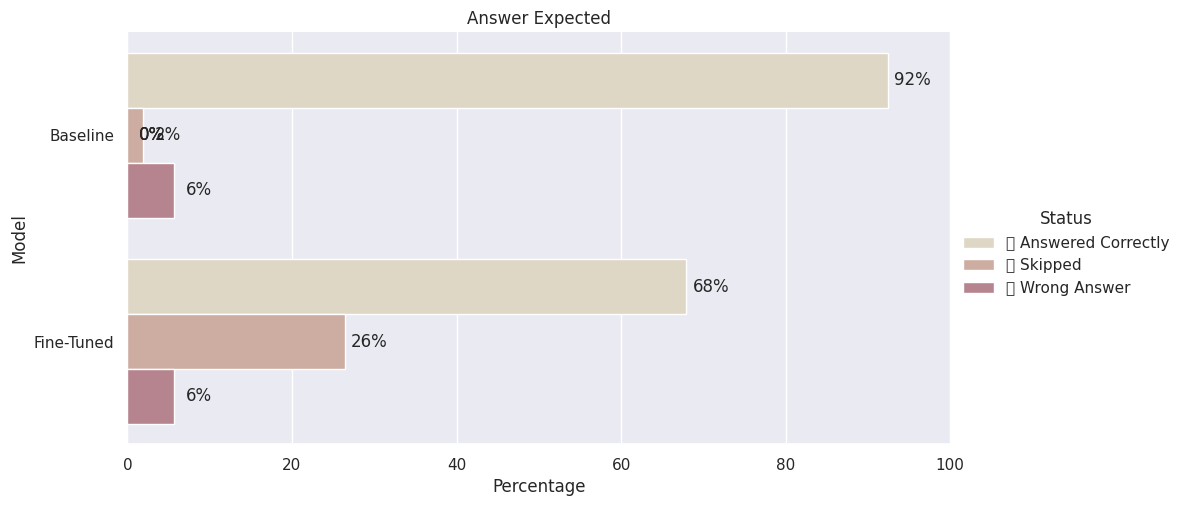

In [ ]:
evaluator.plot_evaluate_model(scenario="answer_expected")

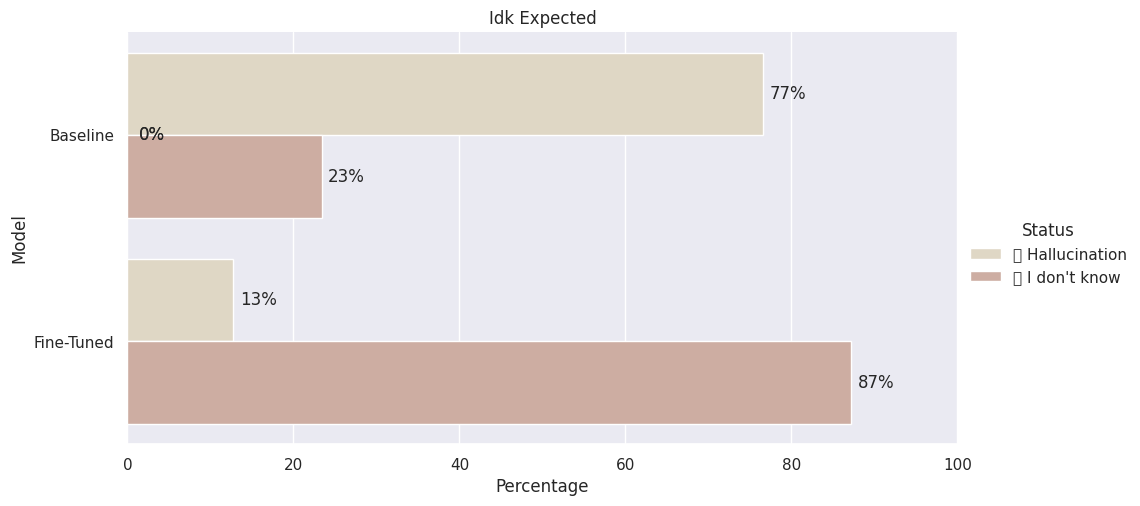

In [ ]:
evaluator.plot_evaluate_model(scenario="idk_expected")

## Few Shot Learning

### Embed the Trainging Data

In [ ]:
import os
from google.colab import userdata
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import PointStruct
from qdrant_client.http.models import Distance, VectorParams

In [ ]:
qdrant_client = QdrantClient(
    url=userdata.get("qdrant_url"),
    api_key=userdata.get("qdrant"),
    timeout=6000,
    prefer_grpc=True
)

In [80]:
collection_name = "squadv2-cookbook"

# # Create the collection, run this only once
# qdrant_client.recreate_collection(
#     collection_name=collection_name,
#     vectors_config=VectorParams(size=384, distance=Distance.COSINE),
# )

True

In [114]:
from fastembed.embedding import DefaultEmbedding
from typing import List
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

embedding_model = DefaultEmbedding()

Embedding the Questions

In [ ]:
def genreate_points_from_dataframe(df: pd.DataFrame) -> List[PointStruct]:
  batch_size = 512
  questions = df["question"].tolist()
  total_batches = len(questions) // batch_size + 1

  progress_bar = tqdm(total=len(questions), desc="Generating embeddings")

  # Generating embedding in batches
  embeddings = []
  for i in range(total_batches):
    start_index = i * batch_size
    end_index = min((i+1) * batch_size, len(questions))
    batch = questions[start_index : end_index]

    # Returns the embedding
    batch_embeddings = embedding_model.embed(batch, batch_size=batch_size)

    # Add the returned batch embedding to our list
    embeddings.extend(batch_embeddings)

    # Update progross bar by the batch size
    progress_bar.update(len(batch))

  progress_bar.close()

  # Convert from list of array to list of list
  embeddings_list = [embedding.tolist() for embedding in embeddings]

  # Create temporary DataFrame to hold the embeddings and existing DataFrame columns
  temp_df = df.copy()
  temp_df["embeddings"] = embeddings_list
  temp_df["id"] = temp_df.index

  # Generate PointStruct objects using DataFrame apply method
  points = temp_df.progress_apply(
      lambda row: PointStruct(
          id=row["id"],
          vector=row["embeddings"],
          payload={
              "question": row["question"],
              "title": row["title"],
              "context": row["context"],
              "is_impossible": row["is_impossible"],
              "answers": row["answers"],
          },
      ),
      axis=1,
  ).tolist()

  return points

In [ ]:
points = genreate_points_from_dataframe(train_df)

Generating embeddings:   0%|          | 0/130319 [00:00<?, ?it/s]

  0%|          | 0/130319 [00:00<?, ?it/s]

Upload the Embeddings to Qdrant

In [88]:
# This is what an element inside points look like

for element in points[0]:
  print(str(element) + "\n")

('id', 0)

('vector', [-0.020103110000491142, -0.030039820820093155, 0.04416526108980179, -0.02758147567510605, 0.0053002312779426575, 0.06449931859970093, 0.02888783998787403, 0.03356963023543358, 0.031141137704253197, -0.014485775493085384, 0.07239484786987305, 0.05670996382832527, -0.035101570188999176, -0.06548339128494263, -0.006800569128245115, 0.07952339947223663, 0.017717687413096428, -0.12317027151584625, -0.08328627794981003, -0.013064563274383545, -0.08096043765544891, 0.025316249579191208, -0.0003572077548597008, -0.04865385591983795, 0.08842404931783676, -0.020810624584555626, -0.059725236147642136, -0.01841430738568306, -0.06925289332866669, -0.11714693903923035, 0.03208290413022041, 0.044044241309165955, 0.10785617679357529, -0.014908385463058949, -0.061088114976882935, -0.008432297967374325, -0.023131322115659714, 0.019197829067707062, -0.013628384098410606, -0.019711660221219063, 0.026854710653424263, -0.017428601160645485, -0.016906101256608963, -0.09797435998916626, 

In [85]:
# Break up the points into batches and upload the batches on to Qdrant
@retry(wait=wait_exponential(multiplier=1, min=2, max=6))
def qdrant_upsert(points):
  batch_size = 100
  total_batches= len(points) // batch_size + 1
  progress_bar = tqdm(total=total_batches, desc="Uploading to Qdrant")

  for i in range(total_batches):
    batch = points[i * batch_size : min((i+1) * batch_size, len(points))]
    try:
      qdrant_client.upsert(
            collection_name=collection_name,
            wait=True,
            points=batch
      )
    except Exception as e:
      print(f"Batch {i} failed after retries: {e}")
    progress_bar.update(1)

  progress_bar.close()

In [82]:
qdrant_upsert(points)

Uploading to Qdrant:   0%|          | 0/1304 [00:00<?, ?it/s]

True

Using Qdrant to improve RAG prompt

In [123]:
def get_few_shot_prompt(row):
  query, row_context, row_answer = row["question"], row["context"], row["answers"]

  # Embed the question
  embeddings = list(embedding_model.embed([query]))
  query_embedding = embeddings[0].tolist()

  num_of_qa_to_retrieve = 5

  # Query Qdrant for similiar question that have an answer
  q1 = qdrant_client.search(
      collection_name = collection_name,
      query_vector = query_embedding,
      query_filter = models.Filter(
          must = [
              models.FieldCondition(
                  key = "is_impossible",
                  match = models.MatchValue(
                      value = False,
                  ),
              ),
          ],
      ),
      with_payload = True,
      limit = num_of_qa_to_retrieve,
  )

  # Query Qdrant for similiar questions that are IMPOSSIBLE to answer
  q2 = qdrant_client.search(
      collection_name = collection_name,
      query_vector = query_embedding,
      query_filter = models.Filter(
          must = [
              models.FieldCondition(
                  key = "is_impossible",
                  match = models.MatchValue(
                      value = True,
                  ),
              ),
          ],
      ),
      with_payload = True,
      limit = num_of_qa_to_retrieve
  )

  instruction = """Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n\n"""

  def q_to_prompt(q):
    question, context = q.payload["question"], q.payload["context"]
    answer = q.payload["answers"][0] if len(q.payload["answers"]) > 0 else "I don't know"

    return [
        {
            "role": "user",
            "content": f"""Question: {question}\n\nContext: {context}\n\n\Answer:"""
        },
        {
            "role": "assistant",
            "content": answer
        }
    ]

  rag_prompt = []

  if len(q1) >= 1:
    rag_prompt += q_to_prompt(q1[1])
  if len(q2) >= 1:
    rag_prompt += q_to_prompt(q2[1])
  if len(q1) >= 1:
    rag_prompt += q_to_prompt(q1[2])

  rag_prompt += [
      {
          "role": "user",
          "content": f"""Question: {query}\n\nContent: {row_context}\n\nAnswer:"""
      },
      {
          "role": "assistant",
          "content": row_answer[0] if len(row_answer) > 0 else "I don't know"
      }
  ]

  rag_prompt = [
      {
          "role": "system",
          "content": instruction
      }
  ] + rag_prompt

  return rag_prompt

In [124]:
# An example what the method get_few_shot_prompt produces.
example = get_few_shot_prompt(df.iloc[0])
for element in example:
  print(str(element) + "\n")

{'role': 'system', 'content': "Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n\n"}

{'role': 'user', 'content': 'Question: For what would a bill be submitted to the Supreme Court of Scotland?\n\nContext: Royal assent is the final stage in the legislative process for acts of the Scottish parliament. The process is governed by sections 28, 32, and 33 of the Scotland Act 1998. After a bill has been passed, the Presiding Officer of the Scottish Parliament submits it to the monarch for royal assent after a four-week period, during which the Advocate General for Scotland, the Lord Advocate, the Attorney General or the Secretary of State for Scotland may refer the bill to the Supreme Court of the United Kingdom (prior to 1 October 2009, the Judicial Committee of the Privy Council) for review of its legality. Royal assent is signified by letters patent under the Great Seal of Scotland in the following fo

Add the few_shot_prompt to the train sample

In [125]:
train_sample["few_shot_prompt"] = train_sample.progress_apply(get_few_shot_prompt, axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

Upload the data to fine tune on OpenAI

In [126]:
# Formats the column "few_shot_prompt" into data that can be fine-tuned
def dataframe_to_jsonl(df):
  def create_jsonl_entry(row):
    messages = row["few_shot_prompt"]
    return json.dumps({"messages": messages})

  jsonl_output = df.progress_apply(create_jsonl_entry, axis=1)
  return "\n".join(jsonl_output)

In [127]:
# Write the formated data into disk
with open("local_cache/100_train_few_shot.jsonl", "w") as f:
  f.write(dataframe_to_jsonl(train_sample))

  0%|          | 0/100 [00:00<?, ?it/s]

In [128]:
fine_tuner = openAIFineTuner(
    training_file_path = "local_cache/100_train_few_shot.jsonl",
    model_name = "gpt-3.5-turbo",
    suffix = "qdrant20240628",
    client=client
)

In [ ]:
model_id = fine_tuner.fine_tune_model()
model_id